In [0]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

In [0]:
import requests
import json
import pandas as pd
zones = requests.get("https://api.covid19india.org/zones.json")
data = json.loads(zones.text)
dist_zone={}
for entry in data['zones']:
  # dist_zone_list.append([entry['district'],entry['state'],entry['zone']])
  dist_zone.update({entry['district']:entry['zone']})

districts = requests.get("https://api.covid19india.org/districts_daily.json")
data_district = json.loads(districts.text)
data_cnt=[]
from datetime import datetime
def getCaseAndLastReport(jsonObjectParam):
    cases_dist=pd.DataFrame(jsonObjectParam)
    current=cases_dist.max()
    current_cnf_cnt=current.confirmed
    current_dt=current.date
    previous=cases_dist[cases_dist['confirmed']<current_cnf_cnt].max()
    previous_cnf_cnt=previous.confirmed
    previous_dt=previous.date
    if(pd.isnull(previous_dt)):
      previous_dt='2020-04-21'
    datetime1=datetime.strptime(current_dt,'%Y-%m-%d')
    datetime2=datetime.strptime(previous_dt,'%Y-%m-%d')
    diff=(datetime1-datetime2).days
    return [diff,current_cnf_cnt]

In [0]:
for state in data_district['districtsDaily']:
  for district in data_district['districtsDaily'][state]:
    info=[state,district]
    val=getCaseAndLastReport(data_district['districtsDaily'][state][district])
    data_cnt.append(info+val)


district_df=pd.DataFrame(data_cnt,columns=['State','District','DaysOfNoChange','Count'])
district_df['zone']=district_df['District'].map(dist_zone)


In [13]:
district_df.dropna(inplace=True)
district_df.head()

,State,District,DaysOfNoChange,Count,zone,zone_cd
0,Andaman and Nicobar Islands,North and Middle Andaman,34,1,Green,3.0
1,Andaman and Nicobar Islands,South Andaman,31,32,Red,1.0
3,Andaman and Nicobar Islands,Nicobars,34,0,Green,3.0
4,Andhra Pradesh,Anantapur,6,136,Orange,2.0
5,Andhra Pradesh,Chittoor,6,208,Red,1.0


In [0]:
codes={'Red':1,'Orange':2,'Green':3}
district_df['zone_cd']=district_df['zone'].map(codes)

In [9]:
district_df.dtypes

State              object
District           object
DaysOfNoChange      int64
Count               int64
zone               object
zone_cd           float64
dtype: object

In [0]:
X=district_df[['DaysOfNoChange','Count']].values
y = district_df['zone_cd'].values.astype('int')

In [29]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (588, 2) (588,)
Test set: (148, 2) (148,)


In [50]:
from sklearn import svm
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train) 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
yhat = clf.predict(X_test)

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           1       0.60      0.39      0.47        23
           2       0.64      0.60      0.62        63
           3       0.74      0.89      0.81        62

    accuracy                           0.69       148
   macro avg       0.66      0.63      0.64       148
weighted avg       0.68      0.69      0.68       148

Confusion matrix, without normalization
[[38  6 19]
 [14  9  0]
 [ 7  0 55]]


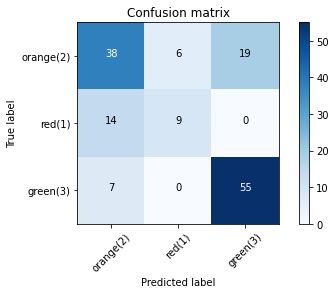

In [54]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,1,3])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['orange(2)','red(1)','green(3)'],normalize= False,  title='Confusion matrix')

In [55]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

0.6776195763849928